In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random
import math
import pandas as pd
from IPython.display import display

# Problema

#### Nossa Função:
$$ f(x_1, x_2) = x_1^4 + x_2sin(x_1) + x_2^4 $$

#### Gradiente:

$$
\nabla f(x_1, x_2) = 

\begin{pmatrix}
    4x_1^3 + x_2cos(x_1)  \\
    4x_2^3 + sin(x_1) 
\end{pmatrix}

$$


#### Hessiana: 

$$
\nabla^2 f(x_1, x_2) = 

\begin{pmatrix}
    12x_1^2 - x_2sin(x_1) & cos(x_1)  \\
    cos(x_1) & 12x_2^2
\end{pmatrix}

$$


# Gráficos

Text(0.5, 0, '$f(x_1, x_2)$')

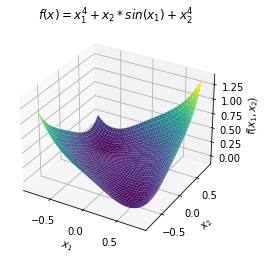

In [2]:
def f(x, y):
    return x**4 + y*np.sin(x) + y**4

x = np.linspace(-.8, .8, 40)
y = np.linspace(-.8, .8, 40)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title(r'$f(x) = x_1^4 + x_2*sin(x_1) + x_2^4$');
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$f(x_1, x_2)$')

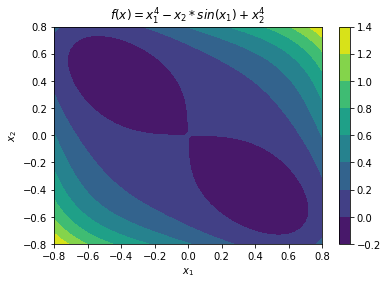

In [3]:
fig,ax=plt.subplots(1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title(r'$f(x) = x_1^4 - x_2*sin(x_1) + x_2^4$')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.show()

# Funções Auxiliares

In [4]:
def f(x):
    return x[0]**4 + x[1]*np.sin(x[0]) + x[1]**4

def getGradient(x):
    return np.array([[4*x[0]**3 + x[1]*np.cos(x[0])], [4*x[1]**3 + np.sin(x[0])]])

def getHessian(x):
    h = np.zeros((2,2))
    h[0,0] = 12*x[0]**2 - x[1]*np.sin(x[0])
    h[1,1] = 12*x[1]**2
    h[0,1] = np.cos(x[0])
    h[1,0] = np.cos(x[0])
    return h

def getDeterminant(A):
    if A.shape != (2,2):
        return
    return A[0,0]*A[1,1] - A[0,1]*A[1,0]

def getInverse(A):
    if A.shape != (2,2):
        return
    det = getDeterminant(A)
    inv = np.zeros((2,2))
    inv[0,0] = A[1,1]
    inv[1,1] = A[0,0]
    inv[1,0] = -1*A[1,0]
    inv[0,1] = -1*A[0,1]
    
    return inv/det

def isPositiveDefinite(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

def armijoSearch(x0, d, k):
    eta = 0.25
    gamma = 0.8
    t = 1
    
    gradient = getGradient(x0)
    while f([x0[0] + t*d[0,0], x0[1] + t*d[1,0]]) > f(x0) + eta*t*(gradient.T.dot(d)[0,0]):
        k += 1
        t = gamma*t

    return t, k

# Métodos de Minimização

In [5]:

def gradientMethod(x0):
    k = 0
    k_armijo = 0
    max_it = 1000
    deltaX = np.array([[1],[1]])
    x = x0
    while k < max_it and np.linalg.norm(getGradient(x)) >= 10**-15 and np.linalg.norm(deltaX) >= 10**-10:
        d = -1*getGradient(x)
        t, k_armijo = armijoSearch(x, d, k_armijo)
        x0 = x
        x = [x[0] + t*d[0,0], x[1] + t*d[1,0]]
        deltaX = np.array([[x[0] - x0[0]], [x[1] - x0[1]]])
        k += 1
    return np.array(x), k, k_armijo

def newtonMethod(x0):
    k = 0
    k_armijo = 0
    max_it = 1000
    deltaX = np.array([[1],[1]])
    x = x0
    while np.linalg.norm(getGradient(x)) >= 10**-15 and k < max_it and np.linalg.norm(deltaX) >= 10**-10:
        h = getHessian(x)
        if not isPositiveDefinite(h):
            break
            
        d = np.dot(-1*getInverse(h), getGradient(x))
        t, k_armijo = armijoSearch(x, d, k_armijo)
        x0 = x
        x = [x[0] + t*d[0,0], x[1] + t*d[1,0]]
        deltaX = np.array([[x[0] - x0[0]], [x[1] - x0[1]]])
        k += 1
    
    return np.array(x), k, k_armijo

def quasiNewtonMethod(x0):
    k = 0
    k_armijo = 0
    max_it = 1000
    
    x = np.array(x0)
    h = np.identity(2)
    q = np.array([[1], [1]])
    p = np.array([[1], [1]])
    
    gradientx0 = getGradient(x0)

    while np.linalg.norm(getGradient(x)) >= 10**-15 \
        and (np.linalg.norm(p) >= 10**-4 or np.linalg.norm(q) >= 10**-4) and k < max_it:
        
        d = np.dot(-1*getInverse(h), getGradient(x))
        t, k_armijo = armijoSearch(x, d, k_armijo)
        x0 = x
        x = [x[0] + t*d[0,0], x[1] + t*d[1,0]]
        
        gradientx = getGradient(x)
        p = np.array([[x[0] - x0[0]], [x[1] - x0[1]]])
        q = gradientx - gradientx0
        gradientx0 = gradientx
        
        # using BFGS
        param1 = 1 + (q.T.dot(h)).dot(q)[0,0]/p.T.dot(q)[0,0]
        param2 = p.dot(p.T)/p.T.dot(q)[0,0]
        param3 = ( p.dot(q.T).dot(h) + h.dot(q).dot(p.T) )/p.T.dot(q)[0,0]
        h = h + param1 * param2 - param3

        k += 1
                
    return x, k, k_armijo 

# Testes e Tabelas

In [6]:
import warnings
warnings.filterwarnings('ignore')

initial_values = []
while(len(initial_values) < 5):
    x0 = [random.uniform(-10.0, 10.0),random.uniform(-10.0, 10.0)]
    if isPositiveDefinite(getHessian(x0)):
        initial_values.append(x0)

methods = [gradientMethod, newtonMethod, quasiNewtonMethod]
method_name = ['Gradient Method', 'Newton Method', 'Quasi Newton Method']
i = 0

for method in methods:
    row_list = []
    for x0 in initial_values:
        x, k, k_armijo = method(x0)
        r = f(x)
        gradient = getGradient(x)
        e = math.sqrt(gradient[0]**2 + gradient[1]**2)

        row = {
            'X0': "( {}, {} )".format(x0[0], x0[1]),
            'Iter.': k, 
            'Call. Armijo': k_armijo,
            'Opt. Point': "( {}, {} )".format(x[0], x[1]),
            'Opt. Value': r, 
            'Error': e 
        }
        row_list.append(row)       
    df = pd.DataFrame(row_list)
    print(method_name[i])
    display(df)
    i+=1
        

Gradient Method


,X0,Iter.,Call. Armijo,Opt. Point,Opt. Value,Error
0,"( 5.350456837380088, -4.327788465468194 )",30,111,"( -0.4761047228215229, 0.4857018887015852 )",-0.115574,6.011285e-11
1,"( 6.997132965666651, 1.0907488196315356 )",27,126,"( 0.47610472280707355, -0.48570188871592923 )",-0.115574,1.677518e-11
2,"( -0.06513585331958716, 4.713982872779825 )",22,111,"( -0.47610472280280597, 0.4857018887158467 )",-0.115574,2.893169e-11
3,"( 8.88976169781478, 8.253899855797325 )",26,185,"( 0.4761047228905667, -0.48570188859651164 )",-0.115574,5.253156e-10
4,"( -6.118863527828946, -6.391120680720757 )",33,149,"( -0.47610472274191556, 0.48570188877711545 )",-0.115574,3.544051e-10


Newton Method


,X0,Iter.,Call. Armijo,Opt. Point,Opt. Value,Error
0,"( 5.350456837380088, -4.327788465468194 )",11,0,"( 0.4761047228103109, -0.48570188871288916 )",-0.115574,5.551115e-17
1,"( 6.997132965666651, 1.0907488196315356 )",12,0,"( 0.4761047228103109, -0.48570188871288916 )",-0.115574,5.551115e-17
2,"( -0.06513585331958716, 4.713982872779825 )",11,5,"( -0.47610472281031097, 0.48570188871288916 )",-0.115574,1.241267e-16
3,"( 8.88976169781478, 8.253899855797325 )",8,0,"( 0.27309676867742694, 0.013939262808084552 )",0.009322,2.859317e-01
4,"( -6.118863527828946, -6.391120680720757 )",7,0,"( -0.17439077395565006, -0.22907988284974207 )",0.043426,3.316987e-01


Quasi Newton Method


,X0,Iter.,Call. Armijo,Opt. Point,Opt. Value,Error
0,"( 5.350456837380088, -4.327788465468194 )",27,287,"( 0.4761189075341164, -0.48570439565134654 )",-0.115574,0.000040
1,"( 6.997132965666651, 1.0907488196315356 )",23,238,"( -0.47611728522239555, 0.48570528441742883 )",-0.115574,0.000034
2,"( -0.06513585331958716, 4.713982872779825 )",38,328,"( -0.4760934513287978, 0.4856984731048412 )",-0.115574,0.000030
3,"( 8.88976169781478, 8.253899855797325 )",18,217,"( -0.47609810984084655, 0.4857020397009141 )",-0.115574,0.000021
4,"( -6.118863527828946, -6.391120680720757 )",30,290,"( -0.4760962516126072, 0.4857011307238832 )",-0.115574,0.000025
